# 시계열 분석

In [ ]:
!git clone https://github.com/joyfulspace/ADP.git

Cloning into 'ADP'...
remote: Enumerating objects: 3035, done.
remote: Counting objects: 100% (898/898), done.
remote: Compressing objects: 100% (613/613), done.
remote: Total 3035 (delta 246), reused 895 (delta 245), pack-reused 2137
Receiving objects: 100% (3035/3035), 116.51 MiB | 23.78 MiB/s, done.
Resolving deltas: 100% (250/250), done.
Checking out files: 100% (2732/2732), done.


## 라이브러리 호출

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
pd.options.display.max_columns = None

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from pmdarima.arima import auto_arima  ## ADP 볼 때는 없을 패키지

import itertools # 내장 패키지

## 그래프 한글 깨짐 방지

In [ ]:
from matplotlib import font_manager, rc
path = 'ADP/file/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

## 데이터 로딩

In [ ]:
raw_df = pd.read_csv('ADP/data/bikeshare.csv')

## 데이터 구조 확인

In [ ]:
raw_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,A,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 1:00,A,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 2:00,A,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 3:00,A,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 4:00,A,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
raw_df.shape

(10886, 12)

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 1020.7+ KB


## 날짜 데이터 전처리

### 날짜 데이터를 Timestamp 형식으로 변환

In [ ]:
# 날짜 형식이 연, 월, 일, 시, 분, 초 형태일 때
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'])
# pd.to_datetime('2012-12-19 20:00', format='%Y-%m-%d %H:%M')

================ 참고 : 날짜형식이 13자리 숫자일 때 대비

In [ ]:
# 13자리 숫자일 때
import datetime
timestamp = 1463460958000
datetimeobj = datetime.datetime.fromtimestamp(timestamp/1000)
print(datetimeobj, type(datetimeobj))
# 이후에 pd.to_datetime으로 변환
a = pd.to_datetime(datetimeobj)
print(a, type(a))

2016-05-17 04:55:58 <class 'datetime.datetime'>
2016-05-17 04:55:58 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
datetimeobj.timetuple()

time.struct_time(tm_year=2016, tm_mon=5, tm_mday=17, tm_hour=4, tm_min=55, tm_sec=58, tm_wday=1, tm_yday=138, tm_isdst=-1)

In [ ]:
# datetime to timestamp
import time
timestamp = time.mktime(datetimeobj.timetuple())
timestamp

1463460958.0

In [ ]:
import datetime
datetime.date(year=2019, month=10, day=1)

datetime.date(2019, 10, 1)

=============== 여기까지

### 날짜 데이터로부터 연, 월, 일, 시, 요일 데이터 추출

In [ ]:
raw_df['year'] = raw_df['datetime'].map(lambda x: x.year) # 연
raw_df['month'] = raw_df['datetime'].map(lambda x: x.month) # 월
raw_df['day'] = raw_df['datetime'].map(lambda x: x.day) # 일
raw_df['hour'] = raw_df['datetime'].map(lambda x: x.hour) # 시
raw_df['dayofweek'] = raw_df['datetime'].map(lambda x: x.dayofweek) # 요일

### 날짜 데이터를 시 기준으로 그룹핑( 다른 데이터는 평균값 계산 ) 후 인덱스로 설정


In [ ]:
# 그룹핑
df = raw_df.groupby(['year','month','day','hour'])['temp','humidity', 'windspeed','count'].mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [ ]:
df.head()

,year,month,day,hour,temp,humidity,windspeed,count
0,2011,1,1,0,9.84,81.0,0.0,16.0
1,2011,1,1,1,9.02,80.0,0.0,40.0
2,2011,1,1,2,9.02,80.0,0.0,32.0
3,2011,1,1,3,9.84,75.0,0.0,13.0
4,2011,1,1,4,9.84,75.0,0.0,1.0


In [ ]:
# 다시 date 컬럼 만들어주기
df['date'] = df['year'].astype('str') +'-'+ df['month'].astype('str') +'-'+ df['day'].astype('str')\
+'-'+ df['hour'].astype('str')

# date 컬럼 형식 변경 -> datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d-%H')

In [ ]:
df = df.set_index('date')

In [ ]:
df.head(3)

,year,month,day,hour,temp,humidity,windspeed,count
date,,,,,,,,
2011-01-01 00:00:00,2011,1,1,0,9.84,81.0,0.0,16.0
2011-01-01 01:00:00,2011,1,1,1,9.02,80.0,0.0,40.0
2011-01-01 02:00:00,2011,1,1,2,9.02,80.0,0.0,32.0


In [ ]:
# 필요 컬럼만 선택
df = df[['temp','humidity','windspeed','count']]

In [ ]:
df.head()

,temp,humidity,windspeed,count
date,,,,
2011-01-01 00:00:00,9.84,81.0,0.0,16.0
2011-01-01 01:00:00,9.02,80.0,0.0,40.0
2011-01-01 02:00:00,9.02,80.0,0.0,32.0
2011-01-01 03:00:00,9.84,75.0,0.0,13.0
2011-01-01 04:00:00,9.84,75.0,0.0,1.0


In [ ]:
# 시계열용 데이터는 따로 빼둠
dfts = pd.DataFrame(df['count'])

In [ ]:
dfts.head()

,count
date,
2011-01-01 00:00:00,16.0
2011-01-01 01:00:00,40.0
2011-01-01 02:00:00,32.0
2011-01-01 03:00:00,13.0
2011-01-01 04:00:00,1.0


     ========  y값 외에독립변수가 더 있을 경우 회귀 같은 비시계열 모델링 추가

### EDA

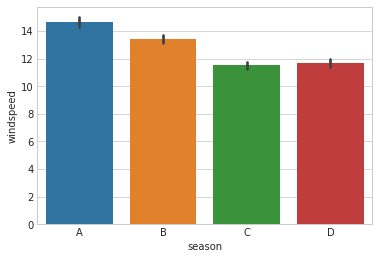

In [ ]:
# 범주형 X별 y의 평균
sns.barplot(x ='season', y = 'windspeed', data = raw_df)

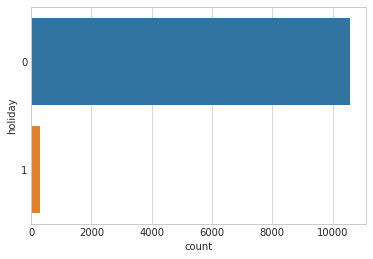

In [ ]:
# 범주형(또는 가지수가 많지 않은 연속형) 변수의 데이터별 count
sns.countplot(y = 'holiday', data = raw_df)

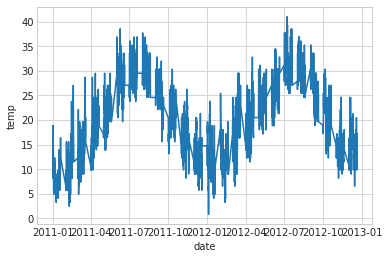

In [ ]:
sns.lineplot(x = df.index, y = 'temp', data = df)

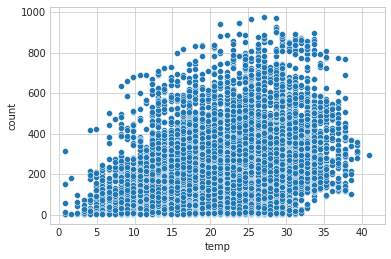

In [ ]:
sns.scatterplot(x = 'temp', y = 'count', data = df)

## 종속변수 분포 확인 및 전처리

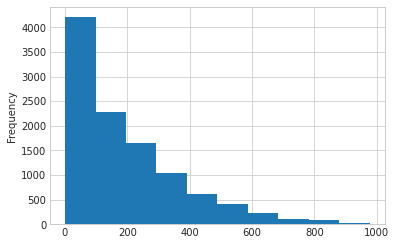

In [ ]:
df['count'].plot(kind='hist')

In [ ]:
df['y2'] = np.log1p(df['count']) # inverse 는 np.expm1()

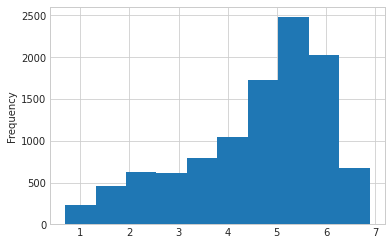

In [ ]:
df['y2'].plot(kind='hist')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10659 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       10659 non-null  float64
 1   humidity   10659 non-null  float64
 2   windspeed  10659 non-null  float64
 3   count      10659 non-null  float64
 4   Frequency  10659 non-null  float64
 5   Monetary   10659 non-null  float64
 6   y2         10659 non-null  float64
dtypes: float64(7)
memory usage: 666.2 KB


In [ ]:
df.head(3)

,temp,humidity,windspeed,count,Frequency,Monetary,y2
date,,,,,,,
2011-01-01 00:00:00,9.84,81.0,0.0,16.0,2.0,157.44,2.833213
2011-01-01 01:00:00,9.02,80.0,0.0,40.0,3.0,360.80,3.713572
2011-01-01 02:00:00,9.02,80.0,0.0,32.0,3.0,288.64,3.496508


## ===========================

In [ ]:
# 데이터를 일부러 줄임(2011년 8월 자료로만)
data = dfts[(dfts.index.year == 2011)&(dfts.index.month == 8)]

In [ ]:
data.shape

(456, 1)

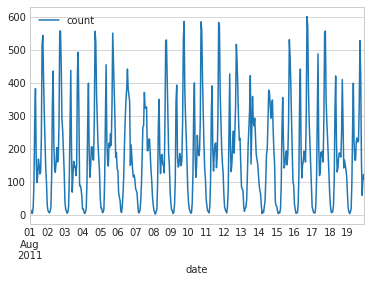

In [ ]:
fig = data.plot()

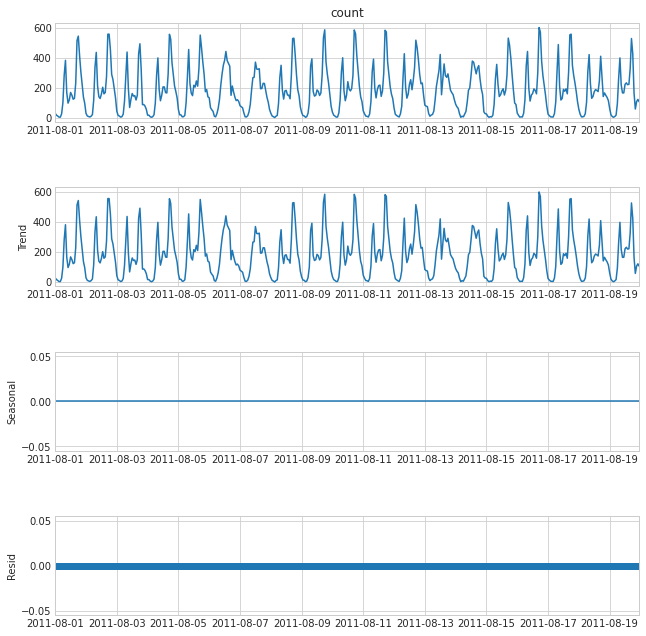

In [ ]:
# Seasonal decomposition plot : Seasonal decomposition using moving averages.
# 참고용으로만 보고 한계점이 많으니 사용하지 않기

# Observed : observed data
# Trend : The estimated trend component. 데이터의 이동평균
# Seasonal : The estimated seasonal component. 트렌드를 제거한 뒤 기간마다 평균냄
# resid : The estimated residuals. 트렌드, 계절성 제거한 나머지 데이터
# model: 값이 전체적으로 일정할 때는 additive, 시간의 흐름에 비례하게 변화하면 multiplicative
decomposition = sm.tsa.seasonal_decompose(data['count'], model = 'additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

## Train, test set split

In [ ]:
data.shape, data.shape[0]*0.8

((456, 1), 364.8)

In [ ]:
# Tr, Te = 8:2
#train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_data = data.iloc[:365]
test_data = data.iloc[365:]

## 정상성 확인
* 시계열 데이터가 AR 특성을 띄면 ACF는 천천히 감소, PACF는 급격히 감소
* 시계열 데이터가 MA 특성을 띄면 ACF는 급격히 감소, PACF는 천천히 감소
* 이를 통해 차분 값 정함

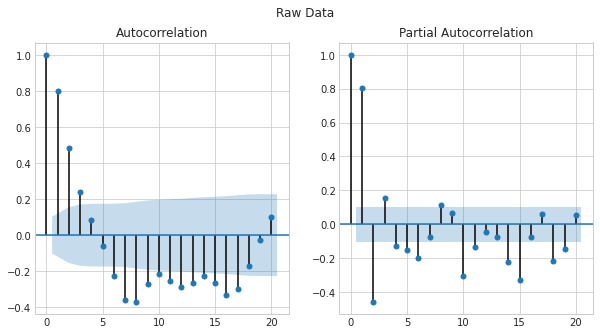

In [ ]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags = 20, ax = ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags = 20, ax = ax[1])
plt.show()
# ACF 그래프가 점진적으로 감소하는 것은 전형적인 Non-stationary 데이터이다 = 정상성이 없음
# ACF는 점진적으로 감소하지만 PACF는 급격히 감소하므로 데이터가 AR특성을 띈다.
# (3, 0, 0) 모델 가능

## 차분

In [ ]:
# Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['count'].diff()
diff_train_data = diff_train_data.dropna()
print('##### Raw Data #####')
print(train_data.head())
print('### Differenced Data ###')
print(diff_train_data.head())

##### Raw Data #####
      count
0 -1.034782
1 -1.116600
2 -1.157508
3 -1.205235
4 -1.205235
### Differenced Data ###
1   -0.081817
2   -0.040909
3   -0.047727
4    0.000000
5    0.149998
Name: count, dtype: float64


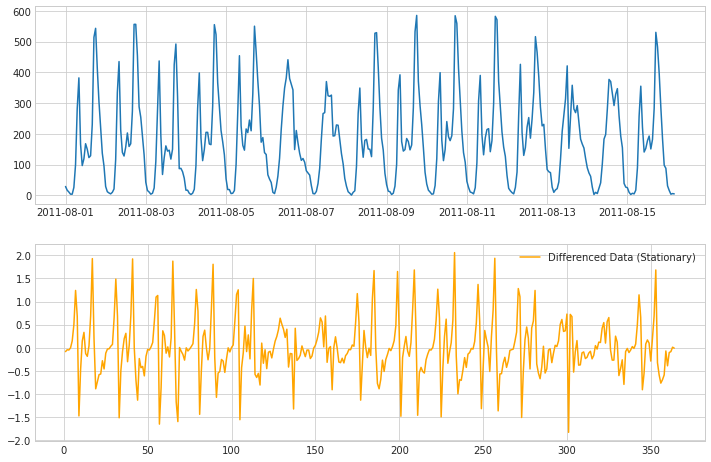

In [ ]:
# differenced data plot

plt.figure(figsize = (12,8))
plt.subplot(211)
plt.plot(train_data['count'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

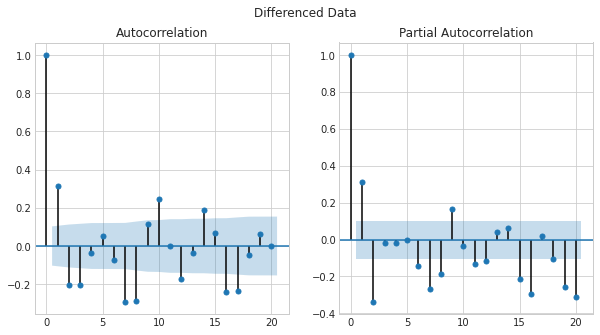

In [ ]:
# ACF, PACF plot

fig, ax = plt.subplots(1,2, figsize = (10, 5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags = 20, ax = ax[0])  # alpha로 신뢰구간 조절 가능
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags = 20, ax = ax[1])
plt.show()

* 차분 1번 했을 때 acf는 1에서 pacf는 2에서 절단값을 가진다.
* 따라서, 가능한 모델은 (0, 1, 1), (2, 1, 0), (2, 1, 1)이다.

## 기본 모델 생성
* acf, pacf 결과에 따라 생성 가능한 모델을 생성하고 AIC 값을 비교해 가장 작은 모델을 최적 모델로 선정
* 통상적으로 p+q<2, p*q=0인 값을 많이 사용

In [ ]:
import os
import sys
sys.stderr = open(os.devnull, "w")  # silence stderr

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)
#warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)

sys.stderr = sys.__stderr__  # unsilence stderr

In [ ]:
# ARIMA model fitting
# The (p, d, q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = ARIMA(train_data.values, order=(2,1,1))
model_fit = model.fit()
model_fit.summary()

# AIC 값은 4251.061이고, constant와 ma.L1.D.y의 p-value 값이 유의미하지 않게 나왔다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2120.530
Method:                       css-mle   S.D. of innovations             81.960
Date:                Fri, 23 Sep 2022   AIC                           4251.061
Time:                        23:46:12   BIC                           4270.547
Sample:                             1   HQIC                          4258.805
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0629      4.580     -0.014      0.989      -9.039       8.913
ar.L1.D.y      0.4749      0.154      3.079      0.002       0.173       0.777
ar.L2.D.y     -0.3521      0.065     -5.428      0.000      -0.479      -0.225
ma.L1.D.y     -0.0656      0.166     -0.395      0.693      -0.391       0.260
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6743           -1.5445j            1.6853           -0.1845
AR.2            0.6743           +1.5445j            1.6853            0.1845
MA.1           15.2350           +0.0000j           15.2350            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
model = ARIMA(train_data.values, order=(0,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2128.729
Method:                       css-mle   S.D. of innovations             83.837
Date:                Fri, 23 Sep 2022   AIC                           4263.458
Time:                        23:46:12   BIC                           4275.150
Sample:                             1   HQIC                          4268.105
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0878      6.464     -0.014      0.989     -12.757      12.581
ma.L1.D.y      0.4723      0.047     10.059      0.000       0.380       0.564
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.1173           +0.0000j            2.1173            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
model = ARIMA(train_data.values, order=(2,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2120.609
Method:                       css-mle   S.D. of innovations             81.977
Date:                Fri, 23 Sep 2022   AIC                           4249.218
Time:                        23:46:13   BIC                           4264.807
Sample:                             1   HQIC                          4255.414
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0653      4.687     -0.014      0.989      -9.252       9.122
ar.L1.D.y      0.4167      0.049      8.448      0.000       0.320       0.513
ar.L2.D.y     -0.3340      0.049     -6.789      0.000      -0.430      -0.238
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6237           -1.6139j            1.7303           -0.1913
AR.2            0.6237           +1.6139j            1.7303            0.1913
-----------------------------------------------------------------------------
"""

## 최적 모델 탐색

In [ ]:
print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p, d, q))

Examples of parameter combinations for Seasonal ARIMA...


In [ ]:
aic=[]
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic,2))

ARIMA: (0, 1, 0) >> AIC : 4325.91
ARIMA: (0, 1, 1) >> AIC : 4263.46
ARIMA: (0, 1, 2) >> AIC : 4262.78
ARIMA: (1, 1, 0) >> AIC : 4290.54
ARIMA: (1, 1, 1) >> AIC : 4264.2
ARIMA: (1, 1, 2) >> AIC : 4208.96
ARIMA: (2, 1, 0) >> AIC : 4249.22
ARIMA: (2, 1, 1) >> AIC : 4251.06
ARIMA: (2, 1, 2) >> AIC : 4205.57


In [ ]:
# Search optimal parameters
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 2), 4205.57)]

In [ ]:
# 위 최적 값으로 만든 모델 다시 Summary

model_opt = ARIMA(train_data.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

# AIC score가 4214.64으로 임의의 모델보다 성능이 좋아졌고, p-value도 모두 유의미하게 나옴

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2096.787
Method:                       css-mle   S.D. of innovations             76.326
Date:                Fri, 23 Sep 2022   AIC                           4205.573
Time:                        23:46:18   BIC                           4228.956
Sample:                             1   HQIC                          4214.867
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.154      0.044      0.965      -0.294       0.308
ar.L1.D.y      0.8796      0.097      9.078      0.000       0.690       1.070
ar.L2.D.y     -0.2165      0.088     -2.457      0.014      -0.389      -0.044
ma.L1.D.y     -0.6178      0.093     -6.631      0.000      -0.800      -0.435
ma.L2.D.y     -0.3822      0.093     -4.112      0.000      -0.564      -0.200
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0314           -0.7015j            2.1491           -0.0529
AR.2            2.0314           +0.7015j            2.1491            0.0529
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -2.6164           +0.0000j            2.6164            0.5000
-----------------------------------------------------------------------------
"""

## Test 데이터 예측

In [ ]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]   # predicted_value 가 y_pred
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

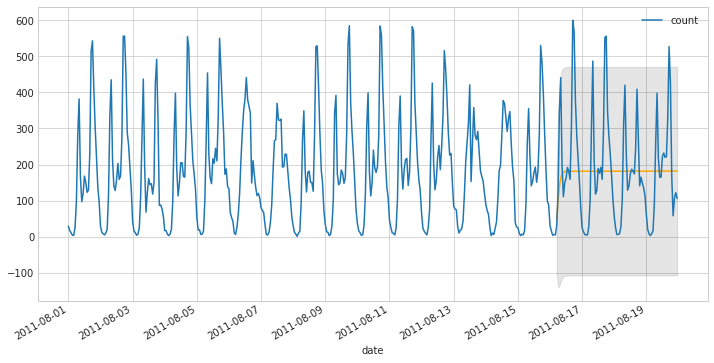

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(predict_index, predicted_value, color = 'orange', label = 'Prediction') # 예측값(위 vline 이후 구간에 표시됨)
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

data.plot(ax = ax);
# ax.vlines('1958-08-01', 0, 1000, linestyle = '--', color = 'r', label = 'Start of Forecast') # x좌표를 날짜로 적음
# ax.legend(loc='upper left')
# plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score: {round(r2,2)})')

plt.show()

# 빨간 점선 이후의 주황색 선이 예측값이며, 회색 구간이 95% interval 구간이다.  # 읭 완전 망했는데
# 대체로 추세를 따라가나 피크 값을 완벽히 예측하기에는 다소 무리가 있는 것을 볼 수 있다.
# R2 score도 0.22 수준인 것을 확인할 수 있었다.

## 성능 평가

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### R^2

In [ ]:
r2 = r2_score(test_data, predicted_value)
r2

-0.0035921274416501614

### MSE

In [ ]:
mse = mean_squared_error(test_data, predicted_value)
mse

21269.074268752014

### RMSE

In [ ]:
rmse = np.sqrt(mse)
rmse

145.8392068983921

### MAE

In [ ]:
mae = mean_absolute_error(test_data, predicted_value)
mae

108.67488497313329

### MAPE

In [ ]:
def mp(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs(y_test - y_pred)/y_test) * 100
# 평균 절대 백분율 오차(MAPE)는 정확도를 오차의 백분율로 표시합니다.
# MAPE는 백분율이기 때문에 다른 정확도 측도 통계량보다 더 쉽게 이해할 수 있습니다. 
# 예를 들어 MAPE가 5이면 예측 값은 평균 5% 벗어납니다

In [ ]:
mape = mp(test_data, predicted_value)
mape

402.0068667002773

## 데이터 생성

In [ ]:
# len(test_data) 자리에 원하는 만큼 숫자 넣어주면 됨

prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]   # predicted_value 가 y_pred
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

## (참고) 계절성 반영 시 SARIMA 모델링 수행

In [ ]:
print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7 # 계절성이 7일마다 있다고 생각해서 7 입력. 얘도 위에 range로 탐색해도 됨
                ) for x in list(itertools.product(p, d, q))]
seasonal_pdq

Examples of parameter combinations for Seasonal ARIMA...


[(0, 1, 0, 7),
 (0, 1, 1, 7),
 (0, 1, 2, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7),
 (1, 1, 2, 7),
 (2, 1, 0, 7),
 (2, 1, 1, 7),
 (2, 1, 2, 7)]

In [ ]:
aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))
        except:
            continue

SARIMA: (0, 1, 0)(0, 1, 0, 7) >> AIC : 4584.54
SARIMA: (0, 1, 0)(0, 1, 1, 7) >> AIC : 4272.4
SARIMA: (0, 1, 0)(0, 1, 2, 7) >> AIC : 4247.62
SARIMA: (0, 1, 0)(1, 1, 0, 7) >> AIC : 4358.07
SARIMA: (0, 1, 0)(1, 1, 1, 7) >> AIC : 4241.72
SARIMA: (0, 1, 0)(1, 1, 2, 7) >> AIC : 4237.9
SARIMA: (0, 1, 0)(2, 1, 0, 7) >> AIC : 4335.92
SARIMA: (0, 1, 0)(2, 1, 1, 7) >> AIC : 4239.39
SARIMA: (0, 1, 0)(2, 1, 2, 7) >> AIC : 4239.76
SARIMA: (0, 1, 1)(0, 1, 0, 7) >> AIC : 4484.03
SARIMA: (0, 1, 1)(0, 1, 1, 7) >> AIC : 4208.57
SARIMA: (0, 1, 1)(0, 1, 2, 7) >> AIC : 4200.83
SARIMA: (0, 1, 1)(1, 1, 0, 7) >> AIC : 4297.7
SARIMA: (0, 1, 1)(1, 1, 1, 7) >> AIC : 4197.91
SARIMA: (0, 1, 1)(1, 1, 2, 7) >> AIC : 4206.75
SARIMA: (0, 1, 1)(2, 1, 0, 7) >> AIC : 4279.06
SARIMA: (0, 1, 1)(2, 1, 1, 7) >> AIC : 4192.9
SARIMA: (0, 1, 1)(2, 1, 2, 7) >> AIC : 4200.34
SARIMA: (0, 1, 2)(0, 1, 0, 7) >> AIC : 4485.76
SARIMA: (0, 1, 2)(0, 1, 1, 7) >> AIC : 4208.67
SARIMA: (0, 1, 2)(0, 1, 2, 7) >> AIC : 4198.74
SARIMA: (0, 1, 2)

In [ ]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

# small pdq는 (1,1,0), large pdq는 (1,1,2) 그리고 Seasonal parameter는 12인 것을 볼 수 있다.

[(((2, 1, 2), (2, 1, 2, 7)), 4150.44)]

In [ ]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

# ARIMA보다 SARIMA가 AIC가 훨씬 낮은 것을 볼 수 있다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood               -2066.221
Date:                           Fri, 23 Sep 2022   AIC                           4150.442
Time:                                   23:53:58   BIC                           4185.342
Sample:                                        0   HQIC                          4164.323
                                           - 365                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9215      0.134      6.867      0.000       0.658       1.185
ar.L2         -0.2211      0.131     -1.689      0.091      -0.478       0.035
ma.L1         -0.6885      2.680     -0.257      0.797      -5.942       4.565
ma.L2         -0.3112      0.880     -0.353      0.724      -2.037       1.414
ar.S.L7       -0.6378      0.557     -1.144      0.253      -1.730       0.455
ar.S.L14      -0.0051      0.143     -0.035      0.972      -0.286       0.276
ma.S.L7       -0.5199      0.677     -0.768      0.443      -1.847       0.807
ma.S.L14      -0.4744      0.556     -0.852      0.394      -1.565       0.616
sigma2      5601.9551   1.47e+04      0.380      0.704   -2.33e+04    3.45e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               125.93
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.73
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Test data 예측 및 성능평가는 위와 동일

In [ ]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

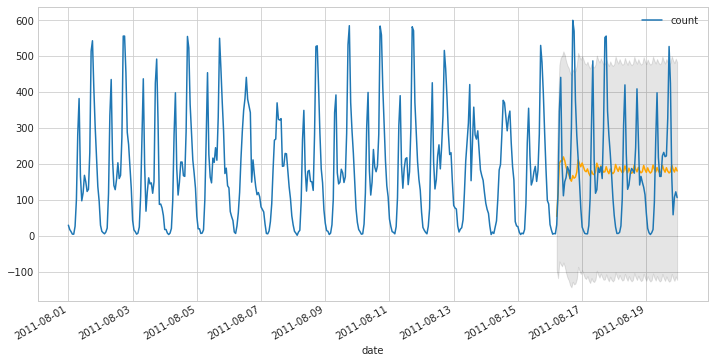

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(predict_index, predicted_value, color = 'orange', label = 'Prediction') # 예측값(위 vline 이후 구간에 표시됨)
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

data.plot(ax = ax);
# ax.vlines('1958-08-01', 0, 700, linestyle = '--', color = 'r', label = 'Start of Forecast') # x좌표를 날짜로 적음
# ax.legend(loc='upper left')
# plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Prediction Results (r2_score: {round(r2,2)})')

plt.show()

# 예측 값의 추세가 실제 값을 상당히 잘 따라가고 있으며,
# r2 score가 0.89로 훨씬 더 성능이 향상됨
# 계절성을 반영한 것이 예측 성능을 향상시키는데 기여를 했다고 볼 수 있다.

## Test data 예측 및 성능평가는 위와 동일

## 추가

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Johnson and Johnson Quaterly Earnings

In [ ]:
data = pd.read_csv('ADP/data/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


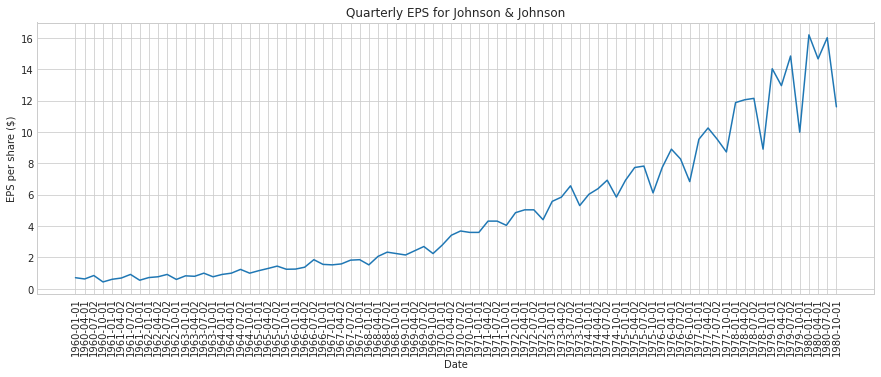

In [ ]:
plt.figure(figsize=[15, 5]); # Set dimensions for figure
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

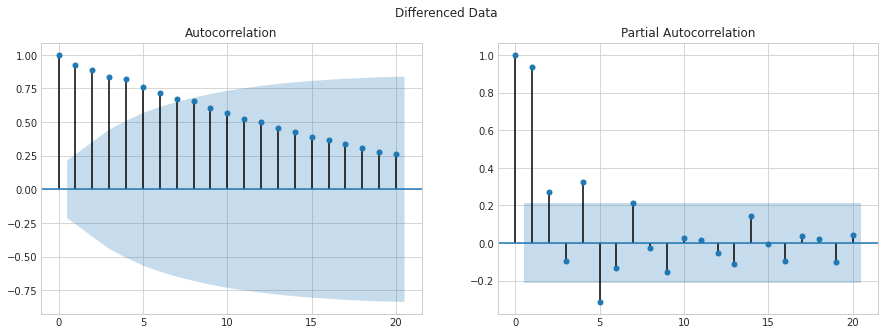

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle('Differenced Data')
plot_acf(data['data'], lags = 20, ax = ax[0])  # alpha로 신뢰구간 조절 가능
plot_pacf((data['data']), lags = 20, ax = ax[1])
plt.show()

### Augmented Dickey-Fuller test (ADF Test)
* Stationary를 정량적인 방법으로 검증
  - 정상성: 평균이 일정, 분산이 일정, 공분산은 시차에만 의존
* 귀무가설: stationary 하지 않다(비정상성이다)
  - p-value가 작고, test statistic이 critical value보다 작은지
  - log로 분산 조절, 차분으로 평균 조절해서 stationary 데이터가 나올 때까지 반복
* 정상성 아닌데 정상성이라고 나오는 경우가 있음
  - 주기까지의 lag가 반영되지 않은 경우이므로 lag를 지정해줌
  - adfuller(y, autolag=None, maxlag=원하는래그값)  


[출처] https://hongl.tistory.com/98

In [ ]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457476
p-value: 1.0


In [ ]:
# Take the log difference to make data stationary

data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

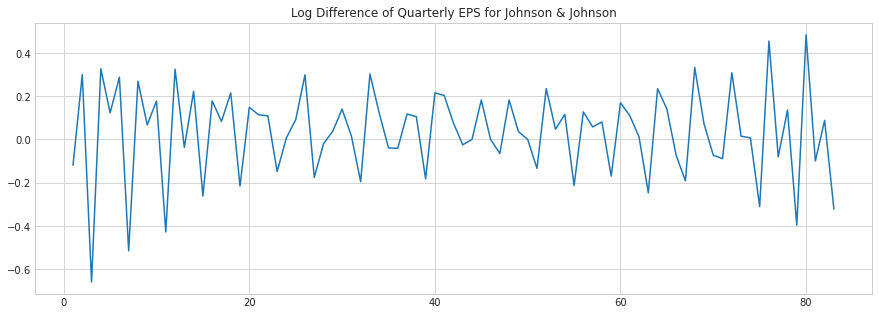

In [ ]:
plt.figure(figsize=[15, 5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [ ]:
# Seasonal differencing
data['diff4'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

,date,data,diff4
0,1961-04-02,0.123233,0.242778
1,1961-07-02,0.287682,-0.011834
2,1961-10-01,-0.514455,0.144006
3,1962-01-01,0.269333,-0.057351
4,1962-04-02,0.067139,-0.056093


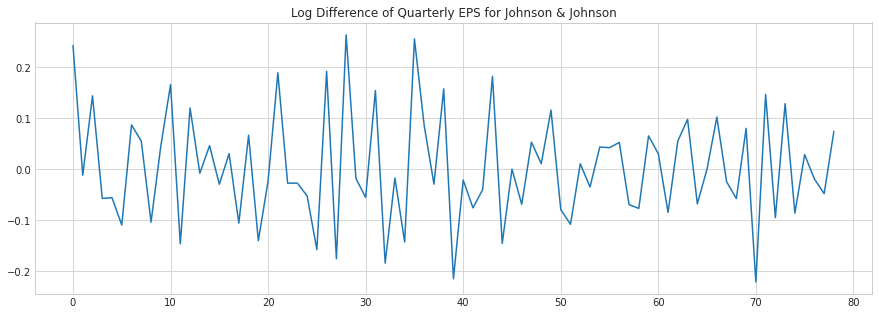

In [ ]:
plt.figure(figsize=[15, 5]); # Set dimensions for figure
plt.plot(data['diff4'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['diff4'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914263
p-value: 5.72157869513621e-09


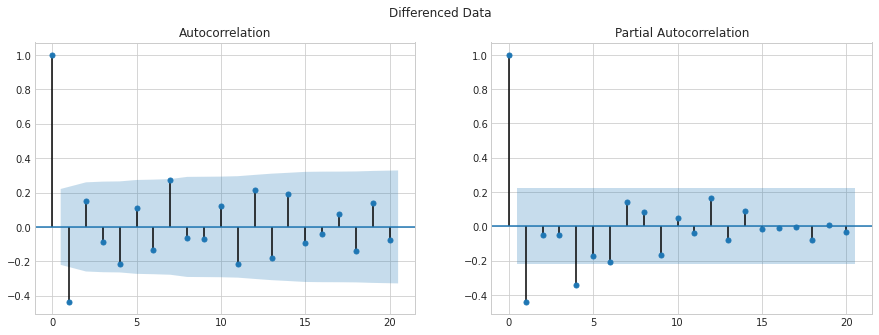

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle('Differenced Data')
plot_acf(data['diff4'], lags = 20, ax = ax[0])  # alpha로 신뢰구간 조절 가능
plot_pacf((data['diff4']), lags = 20, ax = ax[1])
plt.show()

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
parameters_list[0]

(0, 0, 0, 0)

In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df.head(3)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 1)",-137.671376
1,"(0, 2, 1, 0)",-137.200454
2,"(0, 2, 2, 0)",-135.791263


In [ ]:
result_df[result_df.AIC==result_df.AIC.min()]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 1)",-137.671376


In [ ]:
best_model = SARIMAX(data['data'], order=(0, 1, 2), seasonal_order=(0, 1, 1, 4)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                data   No. Observations:                   79
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 4)   Log Likelihood                  72.836
Date:                             Sat, 24 Sep 2022   AIC                           -137.671
Time:                                     01:45:20   BIC                           -128.455
Sample:                                          0   HQIC                          -133.995
                                              - 79                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.6589      0.378     -4.388      0.000      -2.400      -0.918
ma.L2          0.6610      

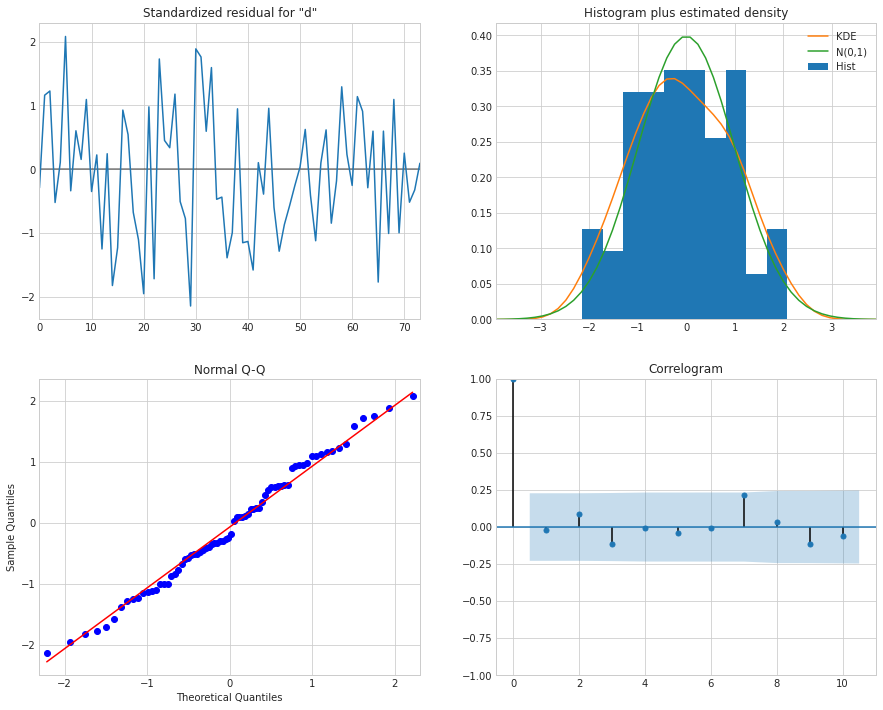

In [ ]:
best_model.plot_diagnostics(figsize=(15,12));

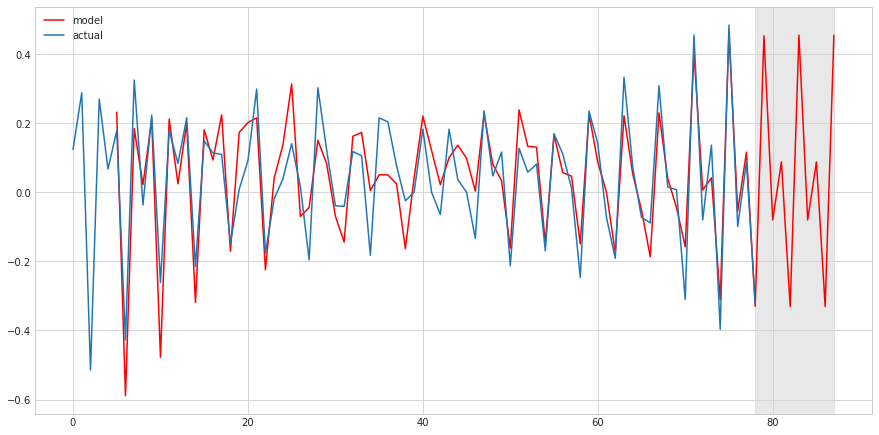

In [ ]:
# 예측 결과
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN # 첫 주기까지(여기서는 4)는 NaN으로 처리하는 듯

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['data'], label='actual')
plt.legend()

plt.show()

### Exponential Smoothing (Holt-Winters)
* 홀트-윈터스의 계절성 기법
  - 덧셈기법: 계절성 변동이 전반적으로 일정할 때
  - 곱셈기법: 계절성 변동이 시계열 수준에 비례하게 변할 때

In [ ]:
data = pd.read_csv('ADP/data/jj.csv')
data.shape

(84, 2)

In [ ]:
train, test = data.iloc[:75,:], data.iloc[75:,:]

In [ ]:
model = ExponentialSmoothing(train['data'], seasonal='mul', seasonal_periods=4).fit()  # seasonal_periods 계절성주기
pred = model.predict(start=test.index[0], end=test.index[-1])

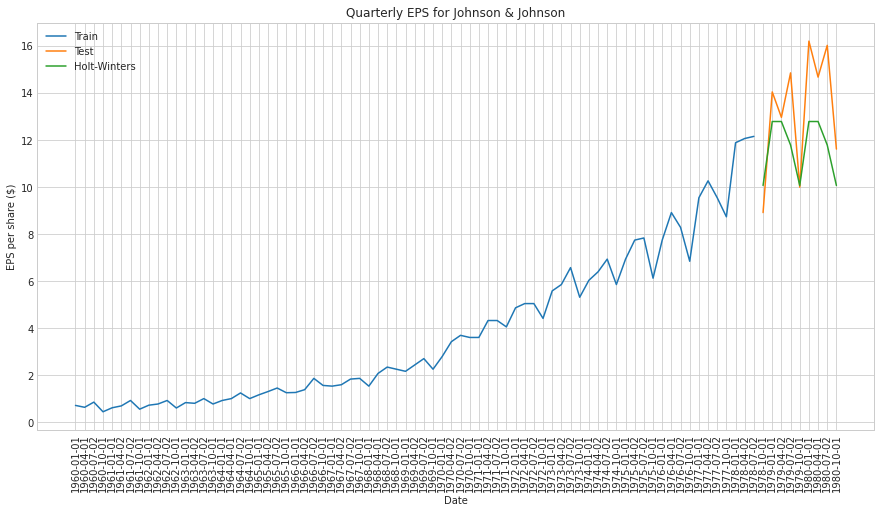

In [ ]:
plt.figure(figsize=(15, 7.5))
plt.plot(train['date'], train['data'], label='Train')
plt.plot(test['date'], test['data'], label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend()
plt.show()